# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 

Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from tqdm.auto import tqdm

In [2]:
!nvidia-smi

Mon Mar 20 21:33:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    17W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# transform = transforms.Compose([transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [5]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [6]:
testset, trainset

(Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ), Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

## Data Preprocessing

In [7]:
BATCH_SIZE = 8
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

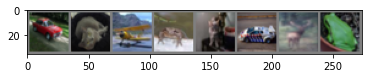

car   cat   plane frog  cat   car   deer  frog 


In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


## Model

In [9]:
# Parameters 


N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

In [10]:
class Backbone(nn.Module):

  def __init__(self, img_size=IMG_DIM, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=False):
    super(Backbone, self).__init__()

    # Boolean to print debug logs.
    self.debug = debug

    self.spaitial_average_pool = nn.AvgPool2d(kernel_size=img_size)
    self.linear = nn.Sequential(
        nn.Linear(in_features=in_channels, out_features=k, bias=True),   # Question, can this be MLP?
        nn.Sigmoid(),      # Non Linear Activation
        # nn.ReLU(),
    )
    # self.non_linear = nn.Sigmoid()       # Non Linear Activation
    # self.non_linear = nn.ReLU()

    self.conv2ds = nn.ModuleList([
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        for _ in range(k)
    ])

  def forward(self, x):
    sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"{sap_out.shape=}")

    g_out = self.linear(sap_out)
    #if self.debug: print(f"{lin_out.shape=}")

    #g_out = self.non_linear(lin_out)
    if self.debug: print(f"{g_out.shape=}")
    if self.debug: print(f"{g_out=}")

    outs = list()
    for a, conv2d in zip(g_out.transpose(0, 1), self.conv2ds):
      c_out = conv2d(x)
      if self.debug: print(f"{c_out.shape=}")
      if self.debug: print(f"{a.shape=}, \n{a=}")

      out = a.reshape(x.shape[0], 1, 1, 1)*c_out
      if self.debug: print(f"{out.shape=}")
      outs.append(out)
      
    out = sum(outs)
    if self.debug: print(f"{out.shape=}")

    return out

  def set_device_to(self, device='cuda'):
    if 'cuda' == device and not torch.cuda.is_available():
      print(f"Cuda not available")
      return

    self.spaitial_average_pool.to(device)
    self.linear.to(device)
    self.non_linear.to(device)

    for conv2d in self.conv2ds:
      conv2d.to(device)

In [11]:
class Model(nn.Module):

  def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
    super(Model, self).__init__()

    # Boolean to print debug logs.
    self.debug = debug
    self.Ks = Ks
    self.channels = channels
    self.img_sizes = [IMG_DIM + (STRIDE-kernel_size)*i for i in range(n+1)]

    if self.debug: print(f"{self.channels=}")
    if self.debug: print(f"{self.img_sizes=}")
    if self.debug: print(f"{self.Ks=}")
    if self.debug: print(f"{n=}")

    self.backbones = nn.ModuleList([
        Backbone(
            img_size=self.img_sizes[i], 
            in_channels=self.channels[i], 
            out_channels=self.channels[i+1], 
            kernel_size=kernel_size, 
            k=self.Ks[i], 
            debug=debug
        ) 
        for i in range(n)
    ])

    self.spaitial_average_pool = nn.AvgPool2d(kernel_size=self.img_sizes[-1])
    self.linear = nn.Linear(in_features=self.channels[-1], out_features=len(CLASSES), bias=False)

  def set_debug(self, debug=True):
    self.debug = debug
    for backbone in self.backbones:
      backbone.debug = debug

  def forward(self, x):
    for backbone in self.backbones:
      x = backbone(x)
    
    f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"M: {f.shape=}")

    out = self.linear(f)
    if self.debug: print(f"M: {out.shape=}")

    return out

In [12]:
class Trainer:

  def __init__(self, model, criterion, optimizer, epochs, trainloader, testloader, logs_per_epoch=4) -> None:
    self.model = model
    self.criterion = criterion
    self.optimizer = optimizer
    
    self.epochs = epochs
    self.log_step = len(trainloader) // logs_per_epoch

    self.trainloader = trainloader
    self.testloader = testloader

    self.losses = list()
    self.val_losses = list()
    self.batch_losses = list()
    
    self.val_accuracy = list()

  def train(self, use_gpu=False):

    for epoch in range(self.epochs):  # loop over the dataset multiple times

        batch_losses = list()
        running_loss = 0.0
        for i, data in tqdm(enumerate(self.trainloader, 0), total=len(trainloader)):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if use_gpu:
              inputs = inputs.to('cuda')
              labels = labels.to('cuda')
            
            # zero the parameter gradients
            self.optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            # print statistics
            batch_losses.append(loss.item())
            running_loss += loss.item()
            if i % self.log_step == self.log_step-1:    # print every 2000 mini-batches
                avg_loss = running_loss / self.log_step
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                running_loss = 0.0
                self.batch_losses.append(avg_loss)

        self.losses.append(sum(batch_losses) / len(batch_losses))

        print(f"Train Loss : {self.losses[-1]}")
        self.eval()

    print('Finished Training')

  def eval(self):
    correct = 0
    total = 0
    losses = list()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in self.testloader:
            images, labels = data
            if USE_GPU:
              images = images.to('cuda')
              labels = labels.to('cuda')

            # calculate outputs by running images through the network
            outputs = self.model(images)

            loss = self.criterion(outputs, labels)
            losses.append(loss.item())

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
    val_loss = sum(losses) / len(losses)
    self.val_losses.append(val_loss)

    print(f"Val Loss : {val_loss}")
    
    accuracy = correct / total
    self.val_accuracy.append(accuracy)
    print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
    
  def plot(self):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 3)

    X = np.linspace(0, len(self.losses)-1, len(self.batch_losses))
    ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', marker='x', linestyle='dashed', lw=1, alpha=0.7)
    ax1.plot(self.losses, label='Train', color='C0', marker='o', lw=3, alpha=1)
    ax1.plot(self.val_losses, label='Test', color='C1', marker='o', lw=3, alpha=1)
    ax1.legend()
    ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')
    
    ax2.plot(self.val_accuracy, label="Test", color='C1', marker='o', lw=3, alpha=1)
    ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
    plt.tight_layout()
    fig.show()
    

In [13]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

In [14]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

channels = [IMG_CHANNELS, 4, 8, 16, 32] #20, 25, 30]
# Ks = channels[1:]
Ks = [5] * (len(channels) - 1)
N = len(channels) - 1

model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)

if USE_GPU: model.to('cuda')


model

self.channels=[3, 4, 8, 16, 32]
self.img_sizes=[32, 28, 24, 20, 16]
self.Ks=[5, 5, 5, 5]
n=4


Model(
  (backbones): ModuleList(
    (0): Backbone(
      (spaitial_average_pool): AvgPool2d(kernel_size=32, stride=32, padding=0)
      (linear): Sequential(
        (0): Linear(in_features=3, out_features=5, bias=True)
        (1): Sigmoid()
      )
      (conv2ds): ModuleList(
        (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
        (1): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
        (2): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
        (3): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
        (4): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
      )
    )
    (1): Backbone(
      (spaitial_average_pool): AvgPool2d(kernel_size=28, stride=28, padding=0)
      (linear): Sequential(
        (0): Linear(in_features=4, out_features=5, bias=True)
        (1): Sigmoid()
      )
      (conv2ds): ModuleList(
        (0): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
        (1): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
        (2): Conv2d(4, 8, ker

In [15]:
# Init optimizer 

LR = 1e-3 #1e-3, 1e-4
MOMENTUM = 0.9 #0.9


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

model.set_debug(False)

In [16]:
# Init Trainer

EPOCHS = 3
BATCH_SIZE = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    epochs=EPOCHS, 
    logs_per_epoch=4,
    trainloader=trainloader,
    testloader=testloader,
)

  0%|          | 0/782 [00:00<?, ?it/s]

[1,   195] loss: 2.049
[1,   390] loss: 1.954
[1,   585] loss: 1.932
[1,   780] loss: 1.885
Train Loss : 1.9545654520354308
Val Loss : 1.8474491447400136
Accuracy of the network on the 10000 test images: 33.62 %


  0%|          | 0/782 [00:00<?, ?it/s]

[2,   195] loss: 1.852
[2,   390] loss: 1.831
[2,   585] loss: 1.821
[2,   780] loss: 1.802
Train Loss : 1.82663890940454
Val Loss : 1.737024857739734
Accuracy of the network on the 10000 test images: 37.29 %


  0%|          | 0/782 [00:00<?, ?it/s]

[3,   195] loss: 1.777
[3,   390] loss: 1.763
[3,   585] loss: 1.745
[3,   780] loss: 1.720
Train Loss : 1.7519446370546774
Val Loss : 1.7013211106039157
Accuracy of the network on the 10000 test images: 39.35 %


  0%|          | 0/782 [00:00<?, ?it/s]

[4,   195] loss: 1.708
[4,   390] loss: 1.699
[4,   585] loss: 1.698
[4,   780] loss: 1.700
Train Loss : 1.7007268417216932
Val Loss : 1.6705648785184144
Accuracy of the network on the 10000 test images: 40.58 %


  0%|          | 0/782 [00:00<?, ?it/s]

[5,   195] loss: 1.687
[5,   390] loss: 1.674
[5,   585] loss: 1.670
[5,   780] loss: 1.662
Train Loss : 1.672895432433204
Val Loss : 1.6564242057739549
Accuracy of the network on the 10000 test images: 40.36 %


  0%|          | 0/782 [00:00<?, ?it/s]

[6,   195] loss: 1.654
[6,   390] loss: 1.640
[6,   585] loss: 1.648
[6,   780] loss: 1.637
Train Loss : 1.6446540457818208
Val Loss : 1.6459551176447778
Accuracy of the network on the 10000 test images: 41.97 %


  0%|          | 0/782 [00:00<?, ?it/s]

[7,   195] loss: 1.632
[7,   390] loss: 1.634
[7,   585] loss: 1.637
[7,   780] loss: 1.628
Train Loss : 1.6324797749824231
Val Loss : 1.6134669970554911
Accuracy of the network on the 10000 test images: 42.69 %


  0%|          | 0/782 [00:00<?, ?it/s]

[8,   195] loss: 1.619
[8,   390] loss: 1.618
[8,   585] loss: 1.599
[8,   780] loss: 1.626
Train Loss : 1.6152696089671397
Val Loss : 1.628342819821303
Accuracy of the network on the 10000 test images: 42.62 %


  0%|          | 0/782 [00:00<?, ?it/s]

[9,   195] loss: 1.605
[9,   390] loss: 1.594
[9,   585] loss: 1.610
[9,   780] loss: 1.593
Train Loss : 1.6008049290808266
Val Loss : 1.6028724225463382
Accuracy of the network on the 10000 test images: 43.63 %


  0%|          | 0/782 [00:00<?, ?it/s]

[10,   195] loss: 1.591
[10,   390] loss: 1.604
[10,   585] loss: 1.597
[10,   780] loss: 1.585
Train Loss : 1.5945340108383648
Val Loss : 1.597013610183813
Accuracy of the network on the 10000 test images: 43.57 %


  0%|          | 0/782 [00:00<?, ?it/s]

[11,   195] loss: 1.586
[11,   390] loss: 1.572
[11,   585] loss: 1.574
[11,   780] loss: 1.591
Train Loss : 1.5800368979458919
Val Loss : 1.585486224502515
Accuracy of the network on the 10000 test images: 44.15 %


  0%|          | 0/782 [00:00<?, ?it/s]

[12,   195] loss: 1.573
[12,   390] loss: 1.571
[12,   585] loss: 1.579
[12,   780] loss: 1.564
Train Loss : 1.5704399072910513
Val Loss : 1.5996028891034946
Accuracy of the network on the 10000 test images: 43.39 %


  0%|          | 0/782 [00:00<?, ?it/s]

[13,   195] loss: 1.551
[13,   390] loss: 1.573
[13,   585] loss: 1.558
[13,   780] loss: 1.567
Train Loss : 1.5626022452893464
Val Loss : 1.5598560662785912
Accuracy of the network on the 10000 test images: 45.46 %


  0%|          | 0/782 [00:00<?, ?it/s]

[14,   195] loss: 1.566
[14,   390] loss: 1.535
[14,   585] loss: 1.576
[14,   780] loss: 1.539
Train Loss : 1.553939354694103
Val Loss : 1.5798832216080587
Accuracy of the network on the 10000 test images: 44.77 %


  0%|          | 0/782 [00:00<?, ?it/s]

[15,   195] loss: 1.551
[15,   390] loss: 1.537
[15,   585] loss: 1.540
[15,   780] loss: 1.571
Train Loss : 1.5499129008759014
Val Loss : 1.5662908667971374
Accuracy of the network on the 10000 test images: 45.14 %


  0%|          | 0/782 [00:00<?, ?it/s]

[16,   195] loss: 1.531
[16,   390] loss: 1.547
[16,   585] loss: 1.556
[16,   780] loss: 1.535
Train Loss : 1.5424838555438438
Val Loss : 1.5606467344199018
Accuracy of the network on the 10000 test images: 45.63 %


  0%|          | 0/782 [00:00<?, ?it/s]

[17,   195] loss: 1.537
[17,   390] loss: 1.522
[17,   585] loss: 1.547
[17,   780] loss: 1.544
Train Loss : 1.5375115924783984
Val Loss : 1.5548820374118295
Accuracy of the network on the 10000 test images: 45.27 %


  0%|          | 0/782 [00:00<?, ?it/s]

[18,   195] loss: 1.522
[18,   390] loss: 1.509
[18,   585] loss: 1.545
[18,   780] loss: 1.531
Train Loss : 1.5263701883118477
Val Loss : 1.555985191825089
Accuracy of the network on the 10000 test images: 46.42 %


  0%|          | 0/782 [00:00<?, ?it/s]

[19,   195] loss: 1.516
[19,   390] loss: 1.533
[19,   585] loss: 1.521
[19,   780] loss: 1.541
Train Loss : 1.527604396385915
Val Loss : 1.551041148270771
Accuracy of the network on the 10000 test images: 45.42 %


  0%|          | 0/782 [00:00<?, ?it/s]

[20,   195] loss: 1.519
[20,   390] loss: 1.523
[20,   585] loss: 1.524
[20,   780] loss: 1.514
Train Loss : 1.5202475638340807
Val Loss : 1.5571955252604879
Accuracy of the network on the 10000 test images: 45.88 %


  0%|          | 0/782 [00:00<?, ?it/s]

[21,   195] loss: 1.526
[21,   390] loss: 1.501
[21,   585] loss: 1.526
[21,   780] loss: 1.513
Train Loss : 1.5169553165240666
Val Loss : 1.5372792740536343
Accuracy of the network on the 10000 test images: 46.70 %


  0%|          | 0/782 [00:00<?, ?it/s]

[22,   195] loss: 1.505
[22,   390] loss: 1.497
[22,   585] loss: 1.523
[22,   780] loss: 1.532
Train Loss : 1.5146188062170278
Val Loss : 1.5546252378232919
Accuracy of the network on the 10000 test images: 45.07 %


  0%|          | 0/782 [00:00<?, ?it/s]

[23,   195] loss: 1.492
[23,   390] loss: 1.516
[23,   585] loss: 1.525
[23,   780] loss: 1.502
Train Loss : 1.509241748648836
Val Loss : 1.5338258674949596
Accuracy of the network on the 10000 test images: 46.00 %


  0%|          | 0/782 [00:00<?, ?it/s]

[24,   195] loss: 1.512
[24,   390] loss: 1.509
[24,   585] loss: 1.498
[24,   780] loss: 1.509
Train Loss : 1.5074479520473334
Val Loss : 1.529731765674178
Accuracy of the network on the 10000 test images: 46.87 %


  0%|          | 0/782 [00:00<?, ?it/s]

[25,   195] loss: 1.518
[25,   390] loss: 1.501
[25,   585] loss: 1.512
[25,   780] loss: 1.487
Train Loss : 1.5036195899214586
Val Loss : 1.5267014252911708
Accuracy of the network on the 10000 test images: 47.14 %


  0%|          | 0/782 [00:00<?, ?it/s]

[26,   195] loss: 1.510
[26,   390] loss: 1.487
[26,   585] loss: 1.495
[26,   780] loss: 1.511
Train Loss : 1.500199659553635
Val Loss : 1.5318738480282437
Accuracy of the network on the 10000 test images: 46.36 %


  0%|          | 0/782 [00:00<?, ?it/s]

[27,   195] loss: 1.495
[27,   390] loss: 1.501
[27,   585] loss: 1.487
[27,   780] loss: 1.503
Train Loss : 1.4958938965407174
Val Loss : 1.5104070210912426
Accuracy of the network on the 10000 test images: 47.82 %


  0%|          | 0/782 [00:00<?, ?it/s]

[28,   195] loss: 1.496
[28,   390] loss: 1.497
[28,   585] loss: 1.494
[28,   780] loss: 1.491
Train Loss : 1.4951695682447586
Val Loss : 1.5613632073068315
Accuracy of the network on the 10000 test images: 45.42 %


  0%|          | 0/782 [00:00<?, ?it/s]

[29,   195] loss: 1.493
[29,   390] loss: 1.493
[29,   585] loss: 1.497
[29,   780] loss: 1.488
Train Loss : 1.4928007636533673
Val Loss : 1.530892422244807
Accuracy of the network on the 10000 test images: 47.05 %


  0%|          | 0/782 [00:00<?, ?it/s]

[30,   195] loss: 1.479
[30,   390] loss: 1.495
[30,   585] loss: 1.498
[30,   780] loss: 1.493
Train Loss : 1.4909170750919205
Val Loss : 1.5286975802889295
Accuracy of the network on the 10000 test images: 46.42 %


  0%|          | 0/782 [00:00<?, ?it/s]

[31,   195] loss: 1.485
[31,   390] loss: 1.488
[31,   585] loss: 1.494
[31,   780] loss: 1.490
Train Loss : 1.4889804954114167
Val Loss : 1.5146060711259295
Accuracy of the network on the 10000 test images: 47.23 %


  0%|          | 0/782 [00:00<?, ?it/s]

[32,   195] loss: 1.487
[32,   390] loss: 1.479
[32,   585] loss: 1.479
[32,   780] loss: 1.502
Train Loss : 1.4867820674196228
Val Loss : 1.5111047090238827
Accuracy of the network on the 10000 test images: 47.08 %


  0%|          | 0/782 [00:00<?, ?it/s]

[33,   195] loss: 1.478
[33,   390] loss: 1.489
[33,   585] loss: 1.487
[33,   780] loss: 1.489
Train Loss : 1.4855556346266472
Val Loss : 1.5165219162679782
Accuracy of the network on the 10000 test images: 47.10 %


  0%|          | 0/782 [00:00<?, ?it/s]

[34,   195] loss: 1.476
[34,   390] loss: 1.473
[34,   585] loss: 1.489
[34,   780] loss: 1.488
Train Loss : 1.4818495829087084
Val Loss : 1.5226433717521133
Accuracy of the network on the 10000 test images: 46.47 %


  0%|          | 0/782 [00:00<?, ?it/s]

[35,   195] loss: 1.474
[35,   390] loss: 1.502
[35,   585] loss: 1.477
[35,   780] loss: 1.471
Train Loss : 1.4811283535969533
Val Loss : 1.5220355896433448
Accuracy of the network on the 10000 test images: 47.21 %


  0%|          | 0/782 [00:00<?, ?it/s]

[36,   195] loss: 1.462
[36,   390] loss: 1.479
[36,   585] loss: 1.484
[36,   780] loss: 1.484
Train Loss : 1.4773912182854265
Val Loss : 1.5224406772358403
Accuracy of the network on the 10000 test images: 46.64 %


  0%|          | 0/782 [00:00<?, ?it/s]

[37,   195] loss: 1.483
[37,   390] loss: 1.477
[37,   585] loss: 1.471
[37,   780] loss: 1.480
Train Loss : 1.4777954585107087
Val Loss : 1.5075466640435966
Accuracy of the network on the 10000 test images: 47.69 %


  0%|          | 0/782 [00:00<?, ?it/s]

[38,   195] loss: 1.487
[38,   390] loss: 1.464
[38,   585] loss: 1.470
[38,   780] loss: 1.481
Train Loss : 1.4755873428586195
Val Loss : 1.5127623764572629
Accuracy of the network on the 10000 test images: 47.33 %


  0%|          | 0/782 [00:00<?, ?it/s]

[39,   195] loss: 1.454
[39,   390] loss: 1.478
[39,   585] loss: 1.493
[39,   780] loss: 1.470
Train Loss : 1.4736021969019604
Val Loss : 1.516979713348826
Accuracy of the network on the 10000 test images: 47.02 %


  0%|          | 0/782 [00:00<?, ?it/s]

[40,   195] loss: 1.467
[40,   390] loss: 1.473
[40,   585] loss: 1.468
[40,   780] loss: 1.478
Train Loss : 1.4715382976605154
Val Loss : 1.515181617372355
Accuracy of the network on the 10000 test images: 47.10 %
Finished Training


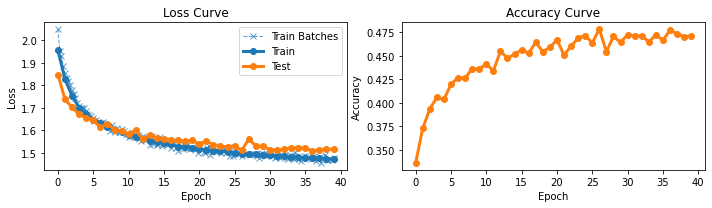

In [17]:
trainer.epochs = 40

trainer.train(use_gpu=USE_GPU)
trainer.plot()